# Experiment 1

- Rank metrics for each model for each product category. The metrics are the average over all folds. (total of 32 weeks)
- Plots over time

In [25]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import yaml
from tqdm import tqdm 

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))

import xgboost as xgb
from xgboost import XGBClassifier
from metrics import mean_absolute_percentage_error, get_metrics
from utils import make_dates
from utils import create_folder

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['olist']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)
    
import mlflow

from glob import glob

from sklearn.metrics import r2_score

In [26]:
prod_categories = params['olist']['product_categories']
date_ranges = make_dates(params['olist']['experiment_dates'])

In [27]:
# Aggregate all predictions of each model for exp1

all_product_categories = {}

base_mae_rmse_ll = []

for prod_cat in prod_categories:
    xgb_exp1 = pd.read_csv(proj_path / catalog['results']['dir'] / f'xgb_exp1_{prod_cat}.csv')
    lstm_exp1 =pd.read_csv(proj_path / catalog['results']['dir'] / f'lstm_exp1_{prod_cat}.csv')
    sarima_exp1 =pd.read_csv(proj_path / catalog['results']['dir'] / f'exp1_sarima_{prod_cat}.csv')
    prophet_exp1 =pd.read_csv(proj_path / catalog['results']['dir'] / f'exp1_prophet_{prod_cat}.csv')

    # clean up each experiments and standardize their outputs here
    xgb_exp1 = xgb_exp1.rename(columns={'preds': 'y_pred_xgb'})
    lstm_exp1 = lstm_exp1.rename(columns={'y_pred': 'y_pred_lstm'})
    sarima_exp1 = sarima_exp1.rename(columns={'lt_preds': 'y_pred_lt_sarima'}) # can be lt_preds
    sarima_exp1 = sarima_exp1.rename(columns={'nd_preds': 'y_pred_sarima'}) # can be lt_preds
    prophet_exp1 = prophet_exp1.rename(columns={'preds': 'y_pred_prophet'})

    # Sets the index the same for all dfs so they can be concatenated based on the index
    xgb_exp1.set_index('dates', inplace=True)
    lstm_exp1.set_index('dates', inplace=True)
    sarima_exp1.set_index('dates', inplace=True)
    prophet_exp1.set_index('dates', inplace=True)

    df = pd.concat([xgb_exp1[['y_true','y_pred_xgb']],
                    sarima_exp1['y_pred_lt_sarima'],
                    sarima_exp1['y_pred_sarima'],
                    lstm_exp1['y_pred_lstm'],
                    prophet_exp1['y_pred_prophet']], axis=1)
    
    base_metrics = pd.read_csv(proj_path / catalog['results']['dir'] / f'naive_training_{prod_cat}.csv')
    
    all_product_categories[prod_cat] = df
    
    base_mae_rmse_ll.append({'product_category': prod_cat,
                             'base_mae':base_metrics['train_mae'].values[0],
                             'base_rmse':base_metrics['train_rmse'].values[0]})
    
base_mae_rmse = pd.DataFrame(base_mae_rmse_ll)


In [28]:
base_mae_rmse

,product_category,base_mae,base_rmse
0,bed_bath_table,34.184211,51.863180
1,health_beauty,23.881579,36.760784
2,sports_leisure,21.276316,29.369022
3,furniture_decor,26.486842,40.182642
4,housewares,21.065789,28.917532
5,watches_gifts,17.105263,28.774989
6,telephony,12.815789,18.551493


In [29]:
all_product_categories['bed_bath_table'].head()

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,y_true,y_pred_xgb,y_pred_lt_sarima,y_pred_sarima,y_pred_lstm,y_pred_prophet
dates,,,,,,
2018-01-07,168,137,192.315611,192.315611,98.501230,146.489462
2018-01-14,205,112,191.703251,192.315611,100.304146,205.037842
2018-01-21,168,137,204.462553,188.794030,100.517920,207.494840
2018-01-28,224,112,203.212866,198.041010,99.655150,149.968304
2018-02-04,237,94,206.899203,206.899203,111.211945,216.758555


In [30]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_sarima = []
    _metrics_lstm = []
    _metrics_prophet = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'], temp['y_pred_xgb']))
        _metrics_sarima.append(get_metrics(temp['y_true'], temp['y_pred_sarima']))
        _metrics_lstm.append(get_metrics(temp['y_true'], temp['y_pred_lstm']))
        _metrics_prophet.append(get_metrics(temp['y_true'], temp['y_pred_prophet']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['sarima','prophet','xgb','lstm'],
                      'min_wape':[pd.DataFrame(_metrics_sarima)['wape'].min(),
                                 pd.DataFrame(_metrics_prophet)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_sarima)['rmse'].min(),
                                 pd.DataFrame(_metrics_prophet)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_sarima)['r2'].min(),
                                 pd.DataFrame(_metrics_prophet)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_sarima)['mape'].min(),
                                 pd.DataFrame(_metrics_prophet)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_sarima)['wape'].max(),
                                 pd.DataFrame(_metrics_prophet)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_sarima)['rmse'].max(),
                                 pd.DataFrame(_metrics_prophet)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_sarima)['r2'].max(),
                                 pd.DataFrame(_metrics_prophet)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_sarima)['mape'].max(),
                                 pd.DataFrame(_metrics_prophet)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max()],
                     'max_mae':[pd.DataFrame(_metrics_sarima)['mae'].max(),
                                 pd.DataFrame(_metrics_prophet)['mae'].max(),
                                 pd.DataFrame(_metrics_xgb)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm)['mae'].max()],
                     'min_mae':[pd.DataFrame(_metrics_sarima)['mae'].min(),
                                 pd.DataFrame(_metrics_prophet)['mae'].min(),
                                 pd.DataFrame(_metrics_xgb)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm)['mae'].min()]})
    

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
metrics_df = pd.DataFrame()
metrics_mase_rmsse = pd.DataFrame()

for prod_cat in prod_categories:
    
    temp = all_product_categories[prod_cat]
    
    # Get metrics for each model
    metrics_xgb = get_metrics(temp['y_true'], temp['y_pred_xgb'])
    metrics_sarima = get_metrics(temp['y_true'], temp['y_pred_sarima'])
    metrics_lstm = get_metrics(temp['y_true'], temp['y_pred_lstm'])
    metrics_prophet = get_metrics(temp['y_true'], temp['y_pred_prophet'])
    
    results = pd.DataFrame([metrics_sarima,metrics_prophet,metrics_xgb,metrics_lstm], 
                       index=['sarima', 'prophet', 'xgb', 'lstm'])
    results['product_category'] = prod_cat
    results = results.reset_index().rename(columns={'index':'model'})
    
    # Calculate the ranks for each metric
    results['rank_mape'] = results.rank(axis=0)['mape']
    results['rank_wape'] = results.rank(axis=0)['wape']
    results['rank_rmse'] = results.rank(axis=0)['rmse']
    results['rank_mae'] = results.rank(axis=0)['mae']
    results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
    
    # Add rank for rmsse and mase
    results = results.merge(base_mae_rmse, how='left', on='product_category')
    results['mase'] = results['mae'] / results['base_mae']
    results['rmsse'] = results['rmse'] / results['base_rmse']
    results['rank_rmsse'] = results.rank(axis=0)['rmsse']
    results['rank_mase'] = results.rank(axis=0)['mase']
    
    min_max_df = get_min_max(df, make_dates(params['olist']['experiment_dates']))
    results = results.merge(min_max_df, how='inner', on='model')
    
    # Calculate the minimum and maximum of each fold.
    
    metrics_df = metrics_df.append(results).reset_index(drop=True)

    # merge base metrics for MASE and RMSSE
    
#     metrics_mase_rmsse = metrics_df.merge(base_mae_rmse, how='left', on='product_category')
#     metrics_mase_rmsse = metrics_mase_rmsse[['model', 'rmse', 'mae', 'product_category', 'base_mae', 'base_rmse']]
#     metrics_mase_rmsse['mase'] = metrics_mase_rmsse['mae'] / metrics_mase_rmsse['base_mae']
#     metrics_mase_rmsse['rmsse'] = metrics_mase_rmsse['rmse'] / metrics_mase_rmsse['base_rmse']

In [32]:
metrics_df[['model', 'product_category', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,product_category,mase,rmsse,rank_mase,rank_rmsse
0,sarima,bed_bath_table,0.981288,0.802323,1.0,1.0
1,prophet,bed_bath_table,1.470127,1.135124,4.0,4.0
2,xgb,bed_bath_table,1.088770,0.936339,2.0,2.0
3,lstm,bed_bath_table,1.375774,1.127358,3.0,3.0
4,sarima,health_beauty,1.803116,1.369516,2.0,2.0
5,prophet,health_beauty,1.613977,1.366835,1.0,1.0
6,xgb,health_beauty,2.325275,1.787045,3.0,3.0
7,lstm,health_beauty,2.755215,1.980740,4.0,4.0
8,sarima,sports_leisure,1.333017,1.242466,1.0,2.0
9,prophet,sports_leisure,1.382059,1.210834,2.0,1.0


In [33]:
metrics_df

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,wape,rmse,r2,mape,mae,product_category,rank_mape,rank_wape,rank_rmse,...,min_wape,min_rmse,min_r2,min_mape,max_wape,max_rmse,max_r2,max_mape,max_mae,min_mae
0,sarima,4187.441517,41.611028,-0.570759,0.218748,33.544571,bed_bath_table,2.0,1.0,1.0,...,453.158822,7.271057,-9.191472,0.067336,3756.590207,47.094104,-0.146266,0.591289,44.093653,6.614373
1,prophet,7126.872312,58.871120,-2.144106,0.289145,50.255138,bed_bath_table,4.0,3.0,4.0,...,391.760132,5.488287,-14.383101,0.061122,1408.708194,28.376757,0.662270,0.389877,25.586313,5.080548
2,xgb,6051.712185,48.561495,-1.139324,0.205683,37.218750,bed_bath_table,1.0,2.0,2.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.750000,16.250000
3,lstm,7616.654626,58.468381,-2.101235,0.261243,47.029757,bed_bath_table,3.0,4.0,3.0,...,416.651967,12.903905,-504.388470,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
4,sarima,5941.012148,50.344481,-0.249845,0.245376,43.061266,health_beauty,2.0,2.0,2.0,...,453.158822,7.271057,-9.191472,0.067336,3756.590207,47.094104,-0.146266,0.591289,44.093653,6.614373
5,prophet,4860.553758,50.245911,-0.244955,0.229281,38.544309,health_beauty,1.0,1.0,1.0,...,391.760132,5.488287,-14.383101,0.061122,1408.708194,28.376757,0.662270,0.389877,25.586313,5.080548
6,xgb,7030.122302,65.693179,-1.128104,0.327671,55.531250,health_beauty,3.0,3.0,3.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.750000,16.250000
7,lstm,9316.824035,72.813561,-1.614429,0.359829,65.798873,health_beauty,4.0,4.0,4.0,...,416.651967,12.903905,-504.388470,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
8,sarima,2598.870615,36.490016,0.015362,0.252619,28.361683,sports_leisure,2.0,1.0,2.0,...,453.158822,7.271057,-9.191472,0.067336,3756.590207,47.094104,-0.146266,0.591289,44.093653,6.614373
9,prophet,2772.247504,35.561019,0.064860,0.248740,29.405132,sports_leisure,1.0,2.0,1.0,...,391.760132,5.488287,-14.383101,0.061122,1408.708194,28.376757,0.662270,0.389877,25.586313,5.080548


In [34]:
all_dfs_mase_rmsse = []
for metric in ['rmsse','mase']:
    rank_df = pd.DataFrame(metrics_df.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_mase_rmsse.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
pd.concat(all_dfs_mase_rmsse,axis=1)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rmsse_1,rmsse_2,rmsse_3,rmsse_4,mase_1,mase_2,mase_3,mase_4
model,,,,,,,,
lstm,NaN,1.0,3.0,3.0,NaN,1.0,3.0,3.0
prophet,6.0,NaN,NaN,1.0,5.0,1.0,NaN,1.0
sarima,1.0,4.0,1.0,1.0,2.0,3.0,1.0,1.0
xgb,NaN,2.0,3.0,2.0,NaN,2.0,3.0,2.0


In [35]:
all_dfs = []
for metric in ['mape','rmse','wape','r2','mae']:
    rank_df = pd.DataFrame(metrics_df.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# View combined of the ranks for each metrics per model
pd.concat(all_dfs,axis=1)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mape_1,mape_2,mape_3,mape_4,rmse_1,rmse_2,rmse_3,rmse_4,wape_1,wape_2,wape_3,wape_4,r2_1,r2_2,r2_3,r2_4,mae_1,mae_2,mae_3,mae_4
model,,,,,,,,,,,,,,,,,,,,
lstm,NaN,1.0,3.0,3.0,NaN,1.0,3.0,3.0,NaN,NaN,2.0,5.0,NaN,1.0,3.0,3.0,NaN,1.0,3.0,3.0
prophet,5.0,1.0,NaN,1.0,6.0,NaN,NaN,1.0,5.0,1.0,1.0,NaN,6.0,NaN,NaN,1.0,5.0,1.0,NaN,1.0
sarima,NaN,5.0,1.0,1.0,1.0,4.0,1.0,1.0,2.0,5.0,NaN,NaN,1.0,4.0,1.0,1.0,2.0,3.0,1.0,1.0
xgb,2.0,NaN,3.0,2.0,NaN,2.0,3.0,2.0,NaN,1.0,4.0,2.0,NaN,2.0,3.0,2.0,NaN,2.0,3.0,2.0


In [37]:
# View individual ranks for each metrics per model
for df_metric in all_dfs:
    display(df_metric)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rank_mape,mape_1,mape_2,mape_3,mape_4
model,,,,
lstm,NaN,1.0,3.0,3.0
prophet,5.0,1.0,NaN,1.0
sarima,NaN,5.0,1.0,1.0
xgb,2.0,NaN,3.0,2.0


rank_rmse,rmse_1,rmse_2,rmse_3,rmse_4
model,,,,
lstm,NaN,1.0,3.0,3.0
prophet,6.0,NaN,NaN,1.0
sarima,1.0,4.0,1.0,1.0
xgb,NaN,2.0,3.0,2.0


rank_wape,wape_1,wape_2,wape_3,wape_4
model,,,,
lstm,NaN,NaN,2.0,5.0
prophet,5.0,1.0,1.0,NaN
sarima,2.0,5.0,NaN,NaN
xgb,NaN,1.0,4.0,2.0


rank_r2,r2_1,r2_2,r2_3,r2_4
model,,,,
lstm,NaN,1.0,3.0,3.0
prophet,6.0,NaN,NaN,1.0
sarima,1.0,4.0,1.0,1.0
xgb,NaN,2.0,3.0,2.0


rank_mae,mae_1,mae_2,mae_3,mae_4
model,,,,
lstm,NaN,1.0,3.0,3.0
prophet,5.0,1.0,NaN,1.0
sarima,2.0,3.0,1.0,1.0
xgb,NaN,2.0,3.0,2.0


In [38]:
all_product_categories['bed_bath_table'].head()

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,y_true,y_pred_xgb,y_pred_lt_sarima,y_pred_sarima,y_pred_lstm,y_pred_prophet
dates,,,,,,
2018-01-07,168,137,192.315611,192.315611,98.501230,146.489462
2018-01-14,205,112,191.703251,192.315611,100.304146,205.037842
2018-01-21,168,137,204.462553,188.794030,100.517920,207.494840
2018-01-28,224,112,203.212866,198.041010,99.655150,149.968304
2018-02-04,237,94,206.899203,206.899203,111.211945,216.758555


In [39]:
#     for model in ['xgb','sarima','lstm','prophet']:
#         upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
#         store_state = params['breakfast']['dataset']['store_ids'][store]
        
#         fig, axs = plt.subplots(2, 1, figsize=(16,10))
#         plt.subplots_adjust(hspace=0.8)
        
#         # Forecasts
#         axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
#         axs[0].plot(temp[f'y_pred_{model}'], marker='o', label='Prediction',alpha=0.8)
#         axs[0].set_title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
#         axs[0].set_xlabel('Date')
#         axs[0].set_ylabel('Units Sold')
#         axs[0].legend()
#         for tick in axs[0].get_xticklabels():
#             tick.set_rotation(40)
#             tick.set_horizontalalignment('right')
            
#         # Residuals
#         axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}']), marker='o', label='Residuals', alpha=0.8)
#         axs[1].plot([0]*temp.shape[0])
#         axs[1].set_title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
#         axs[1].set_xlabel('Date')
#         axs[1].set_ylabel('Residuals')
#         axs[1].legend()
#         for tick in axs[1].get_xticklabels():
#             tick.set_rotation(40)
#             tick.set_horizontalalignment('right')
        
#         plt.show()

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


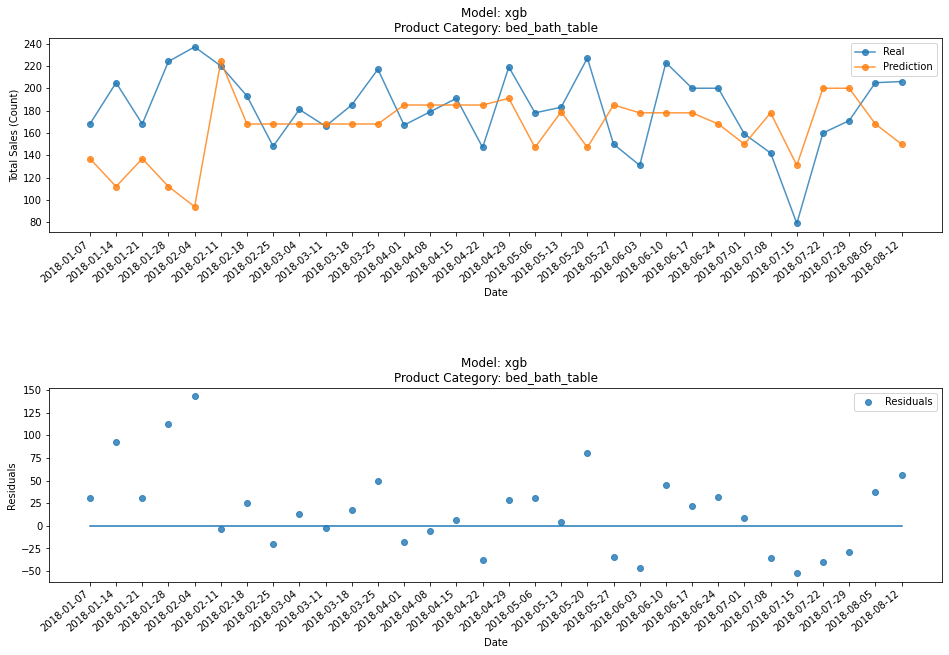

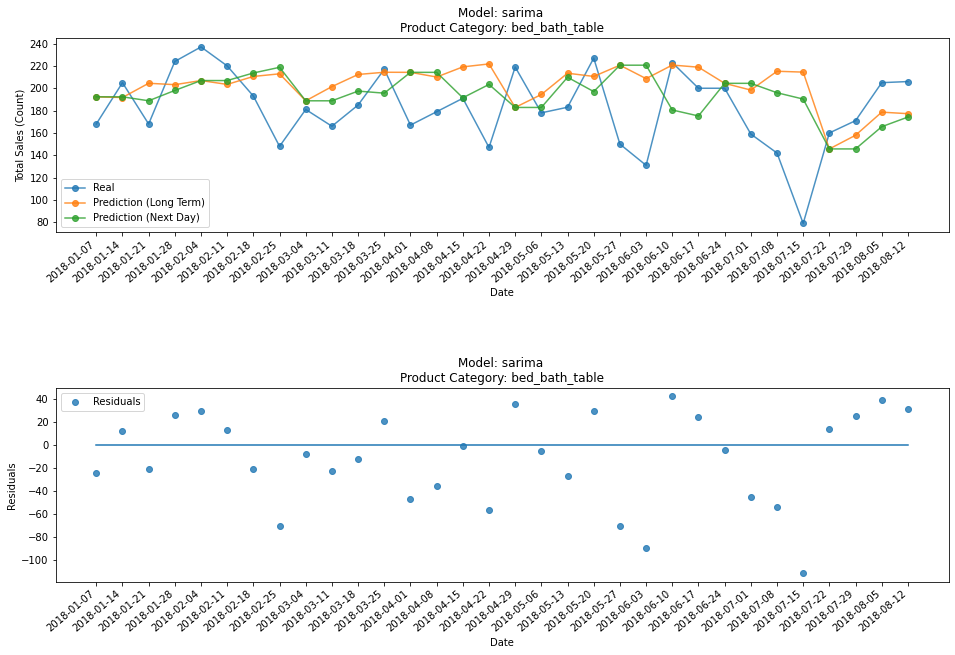

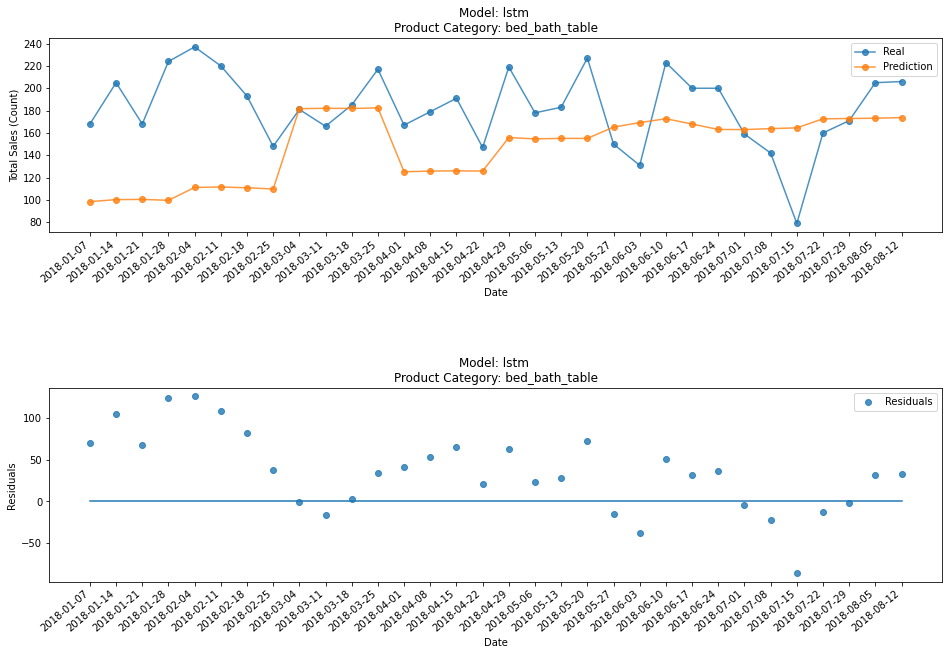

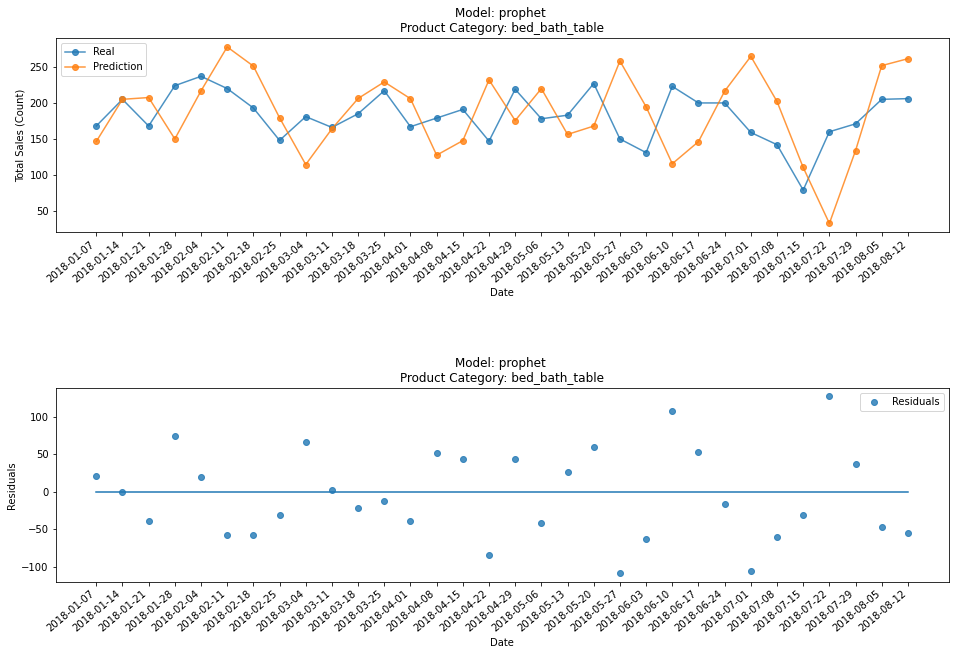

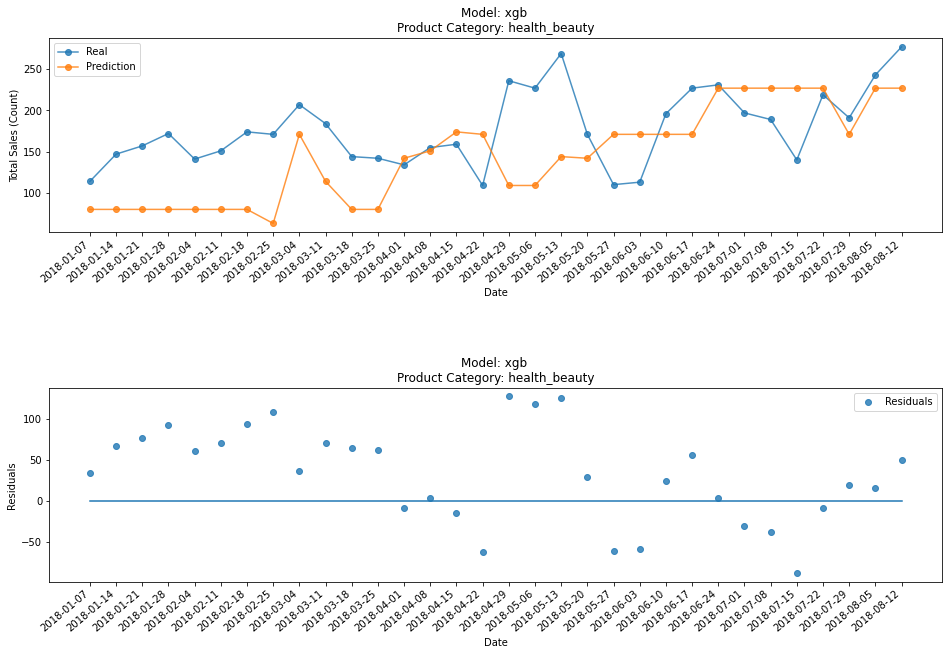

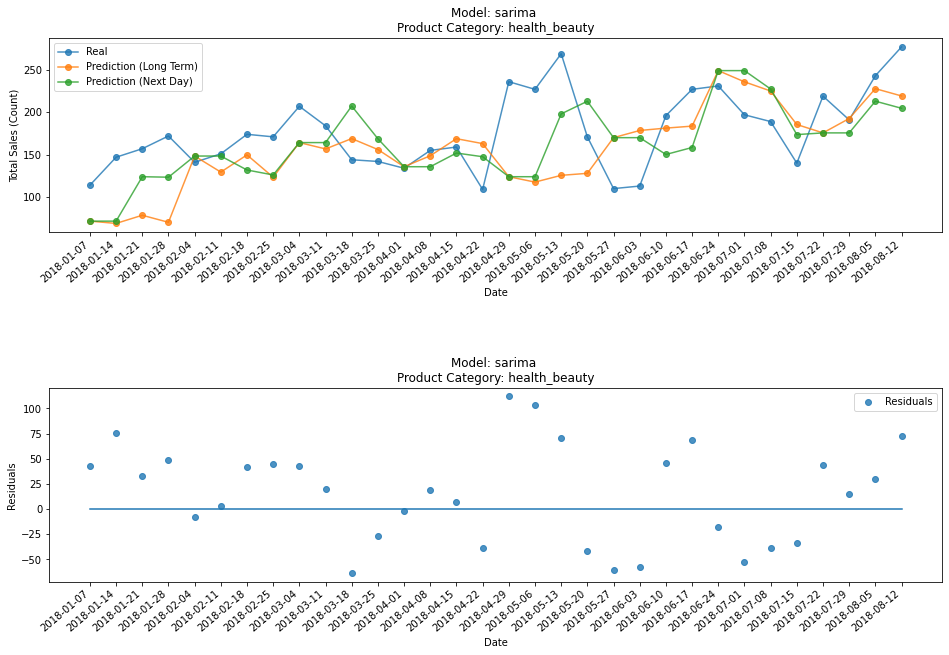

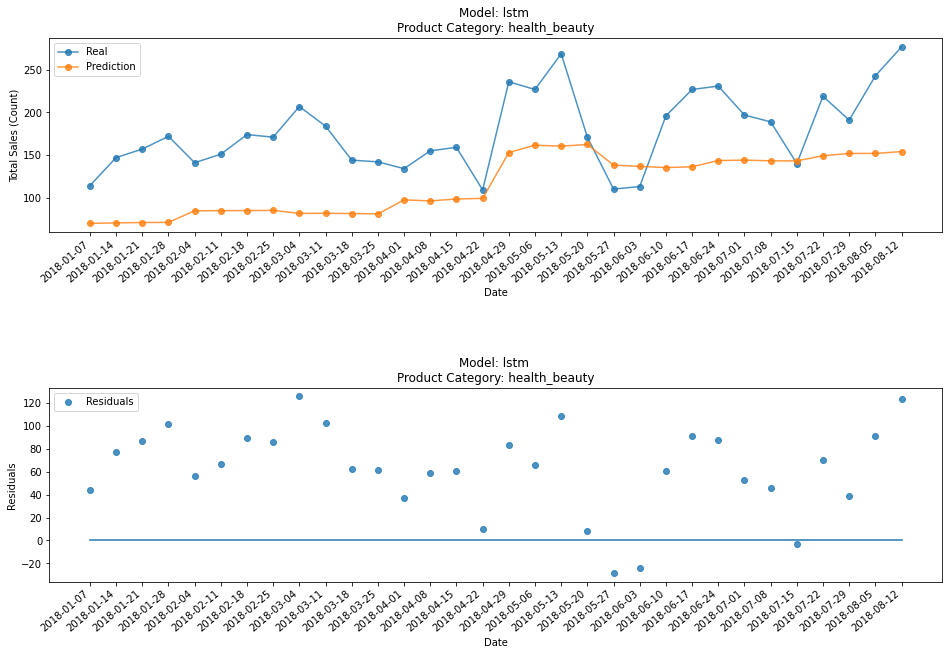

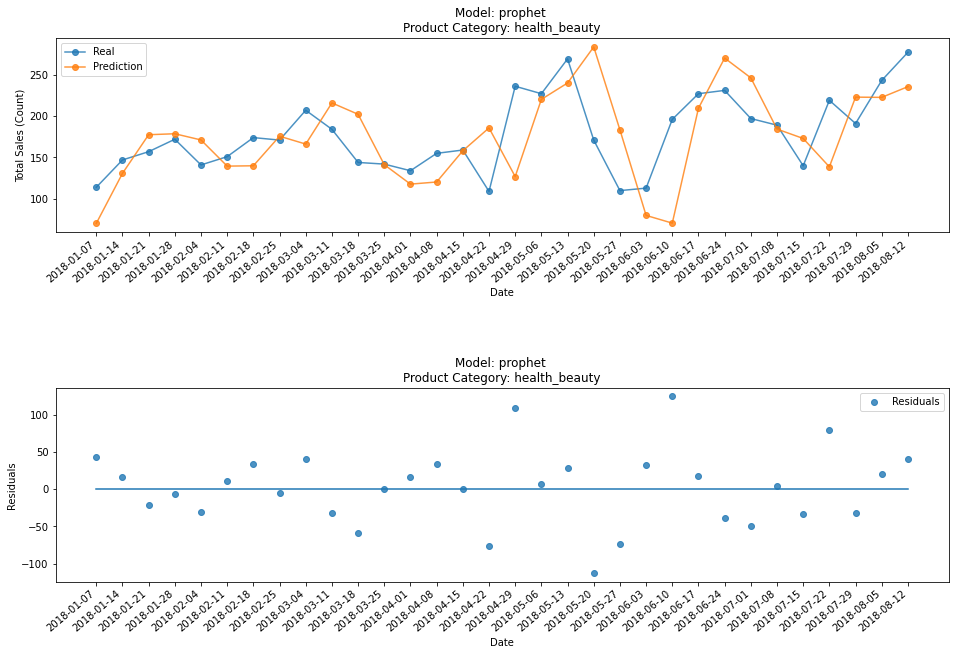

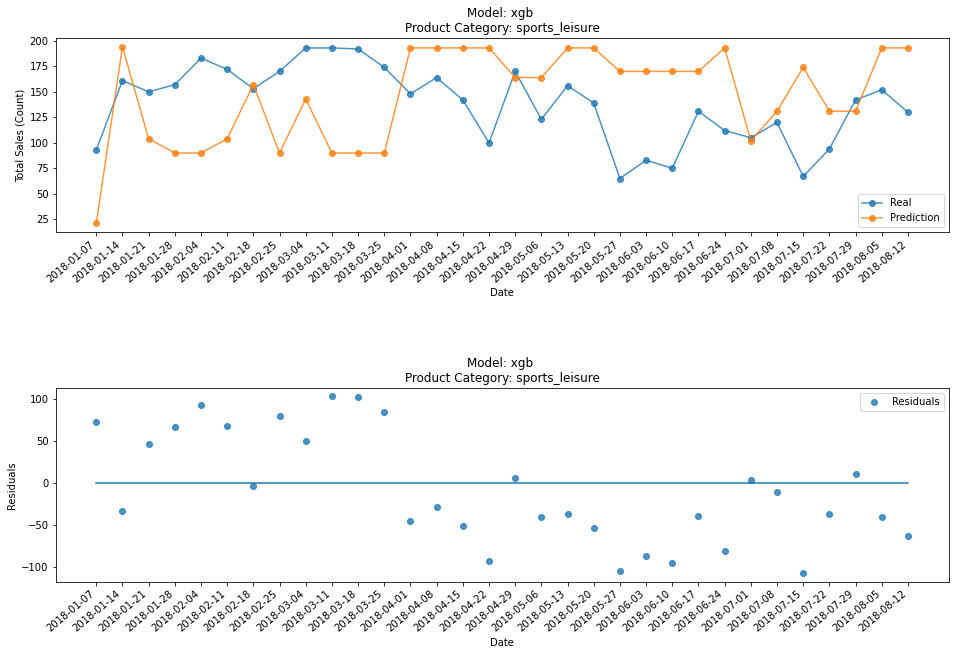

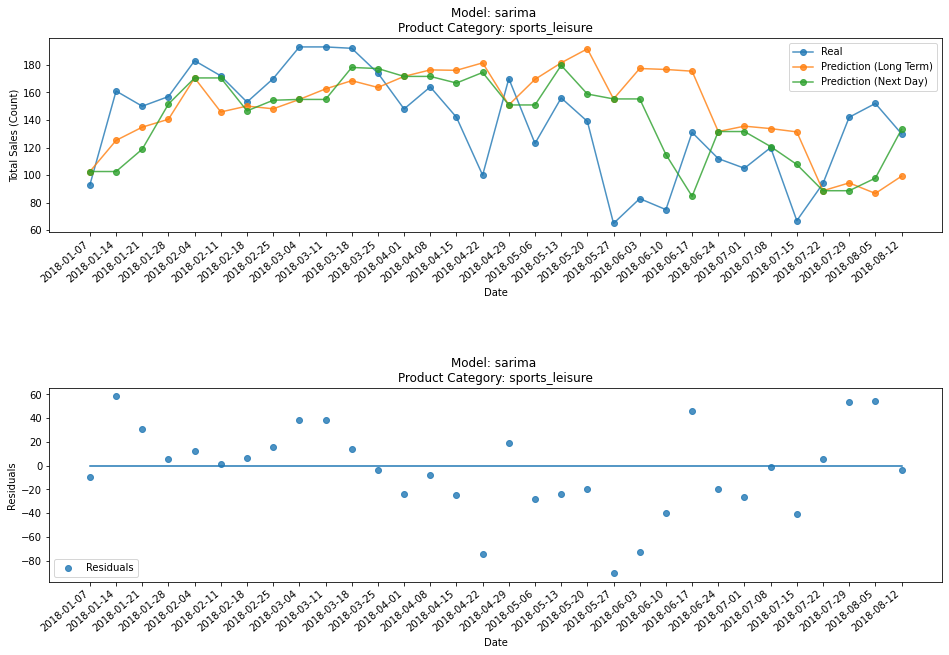

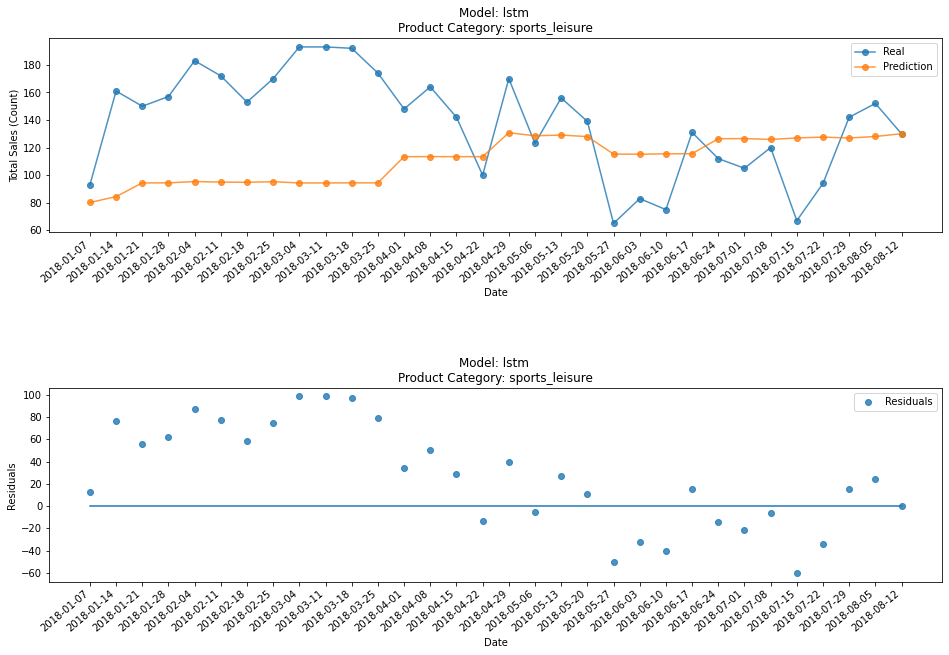

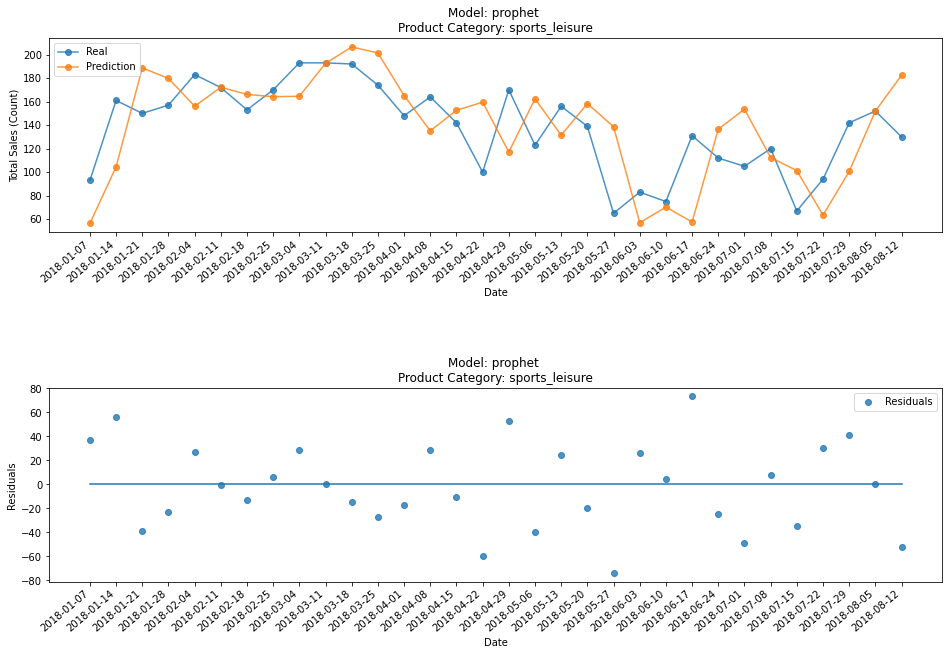

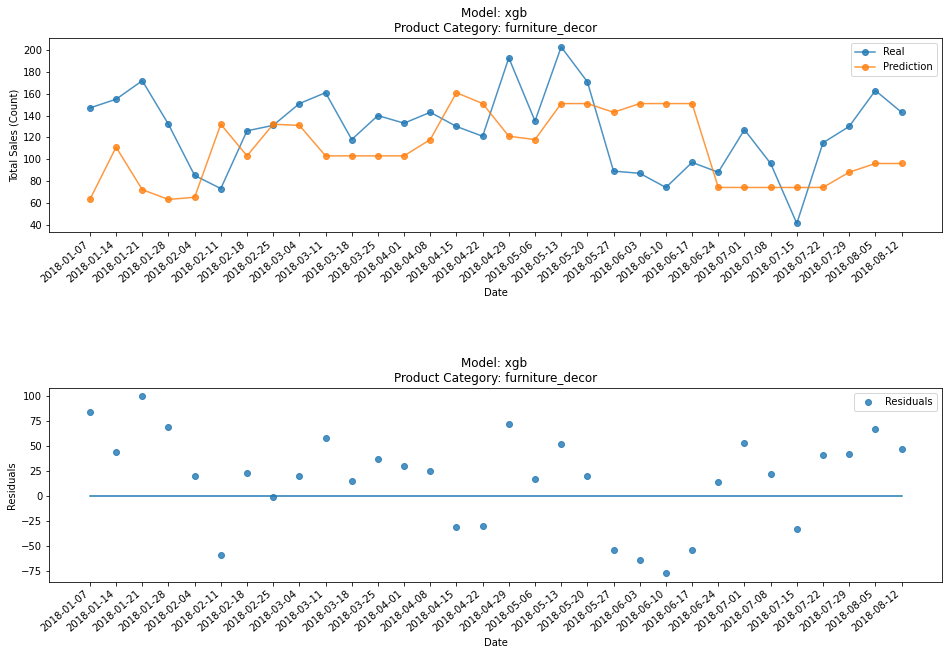

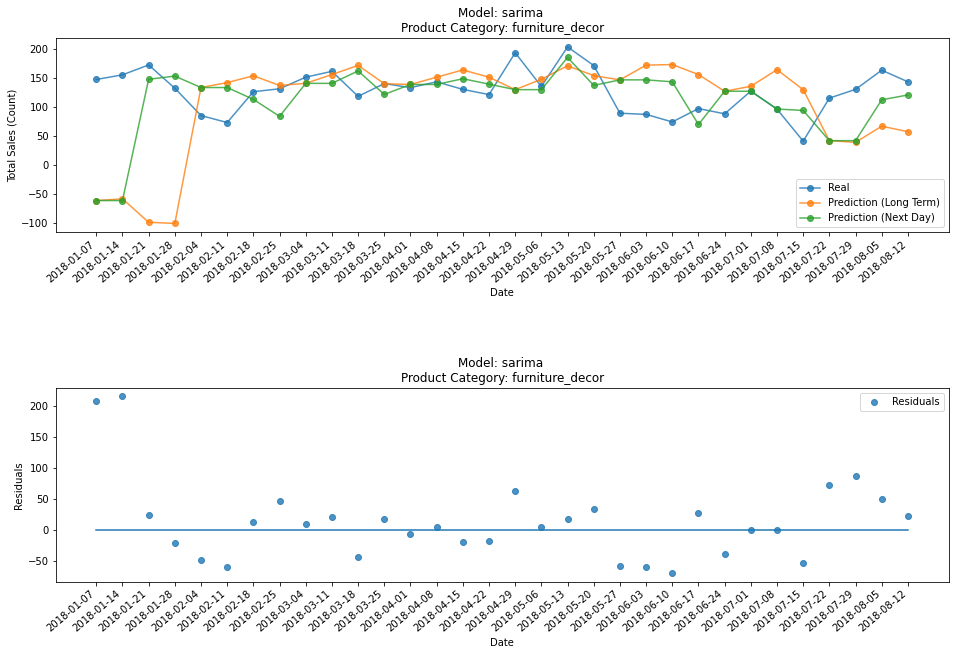

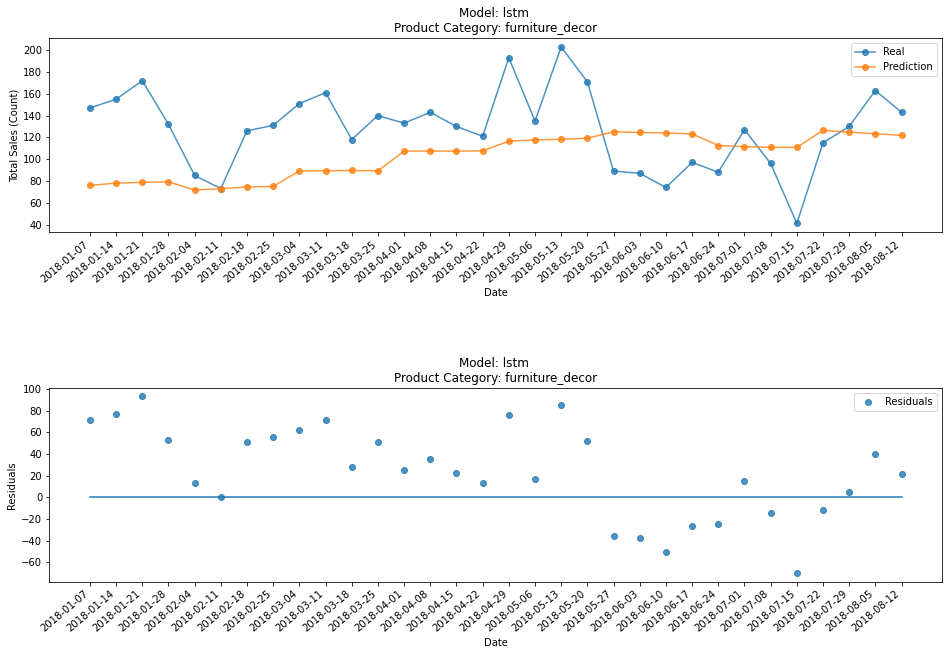

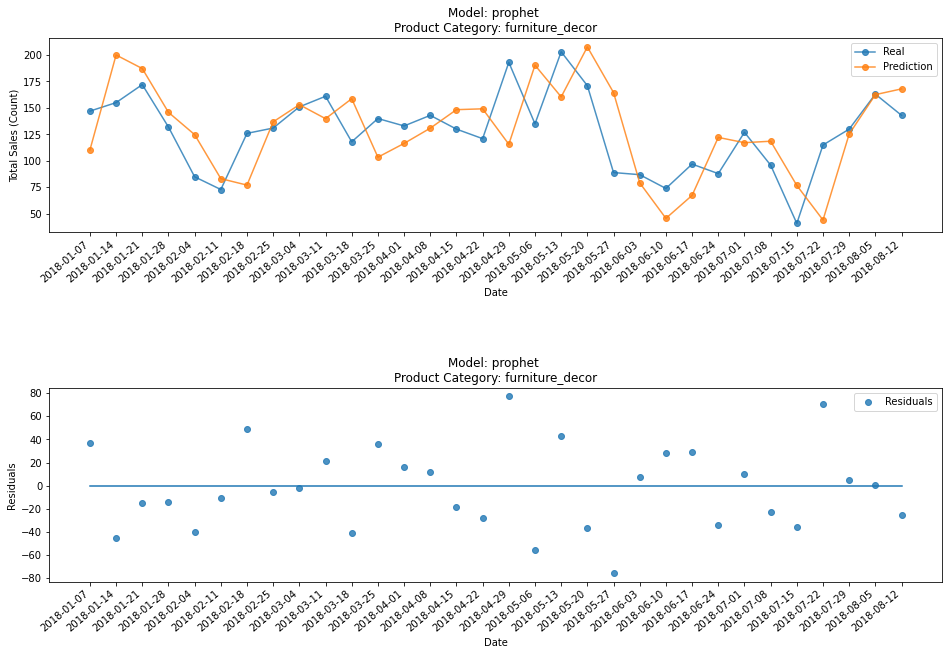

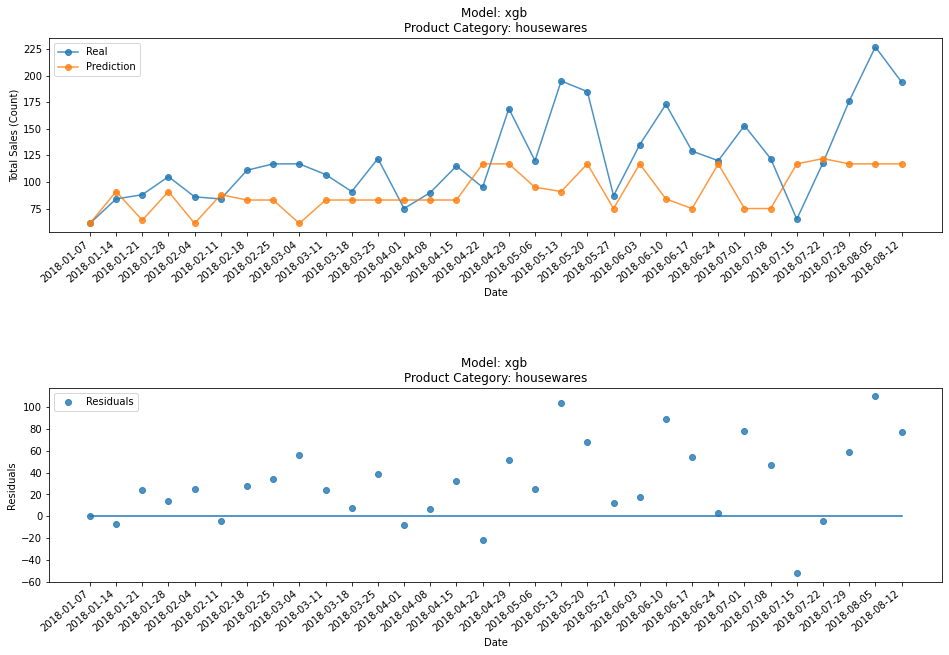

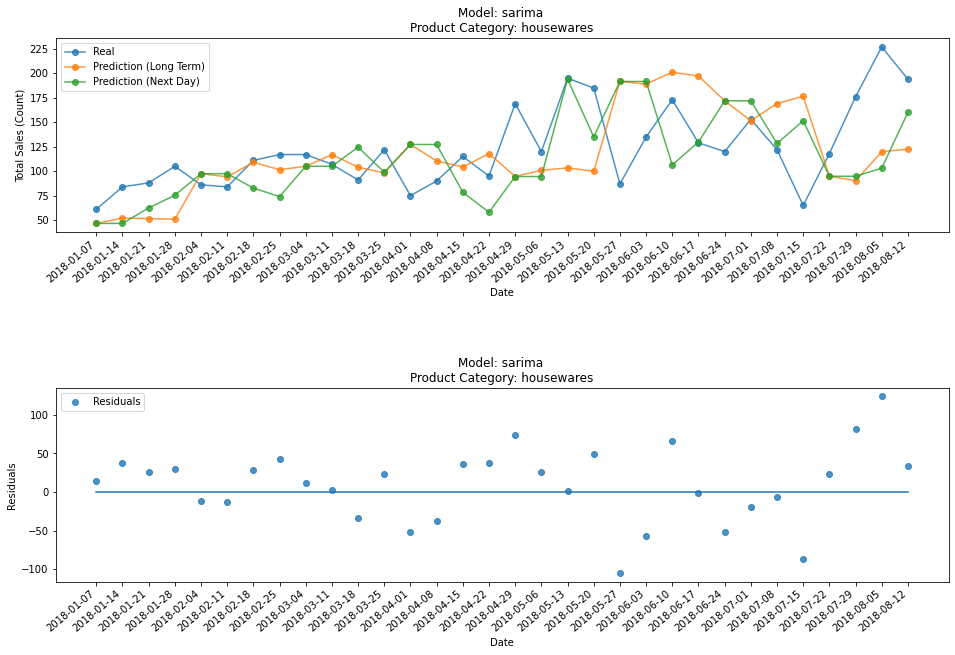

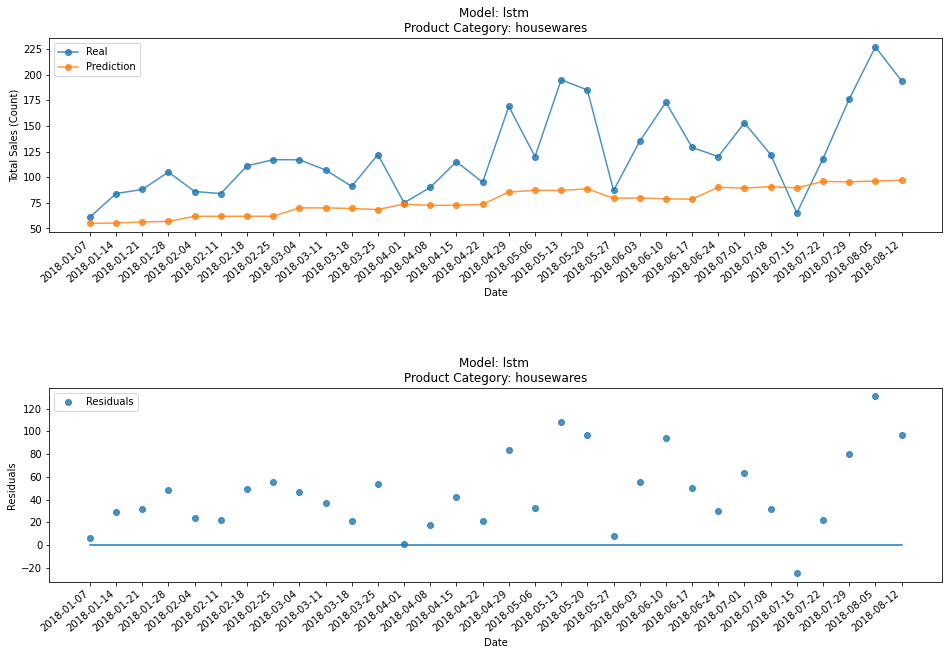

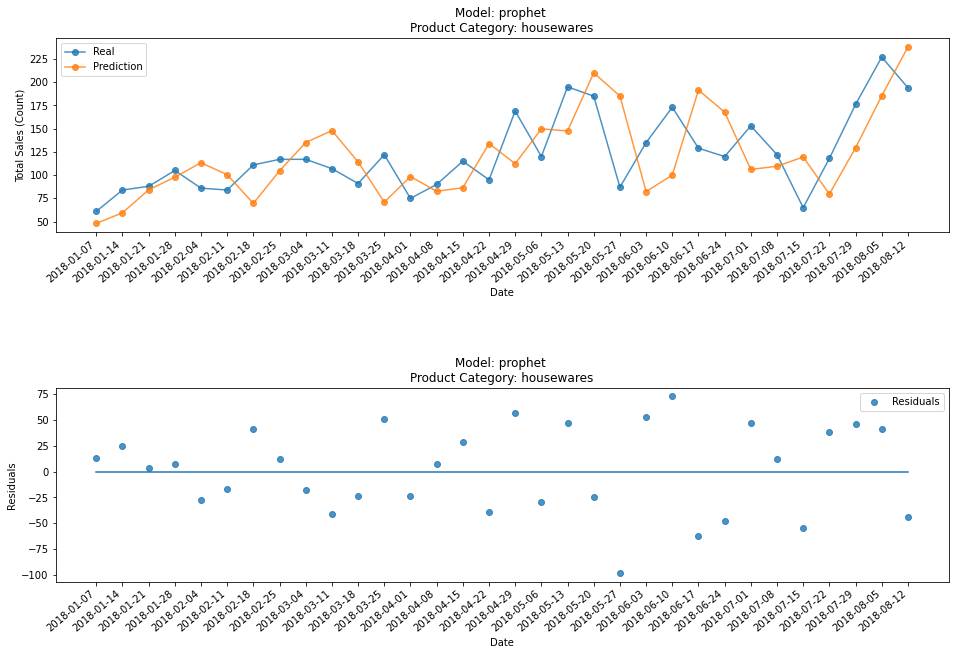

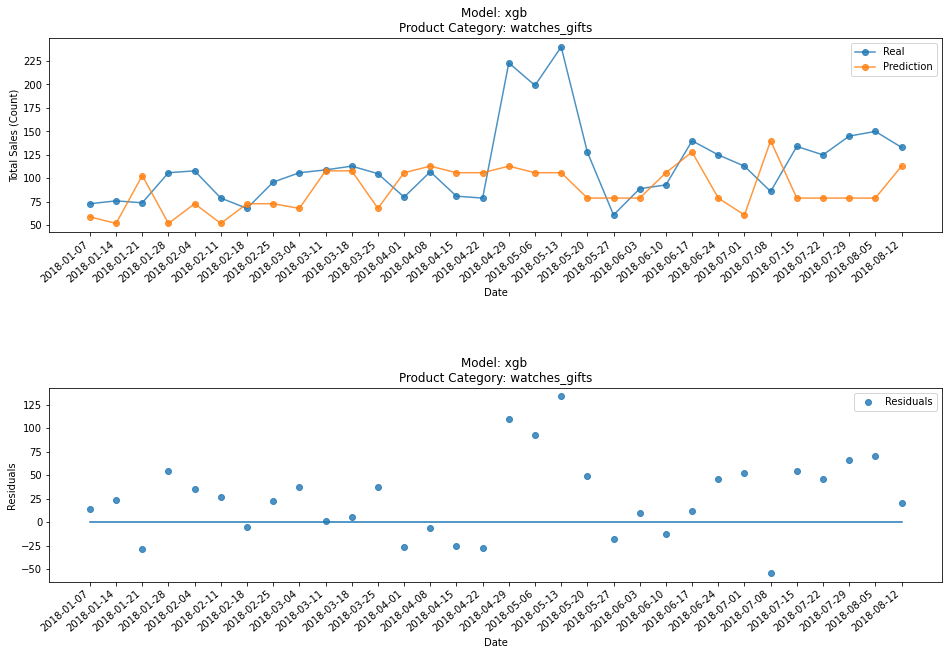

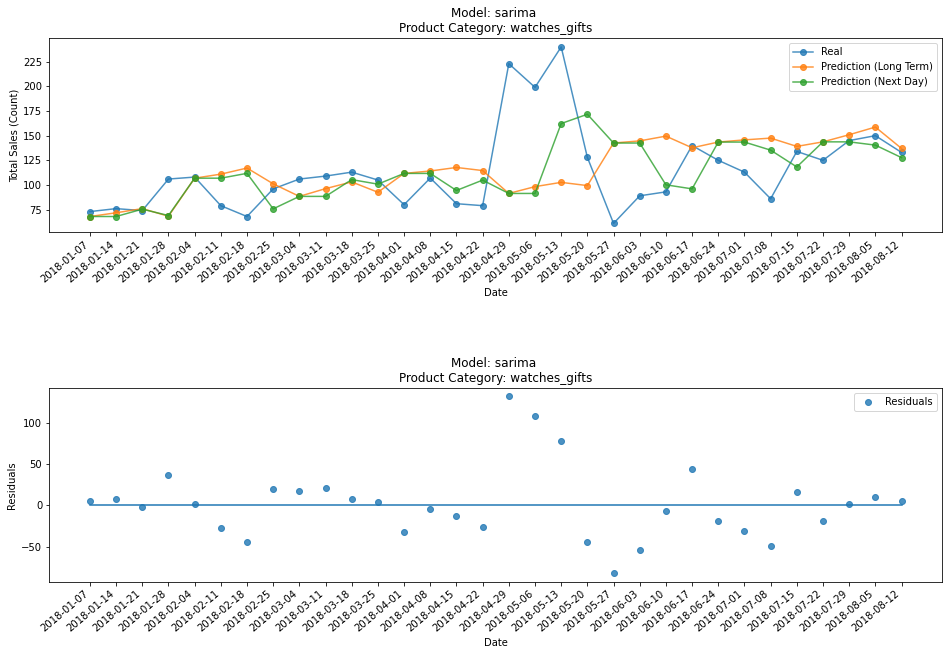

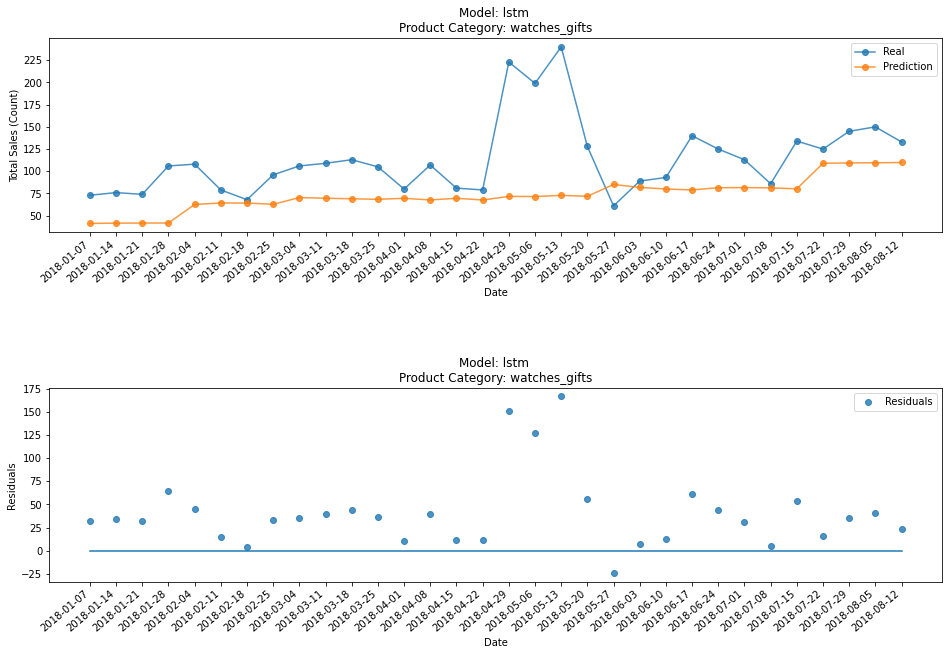

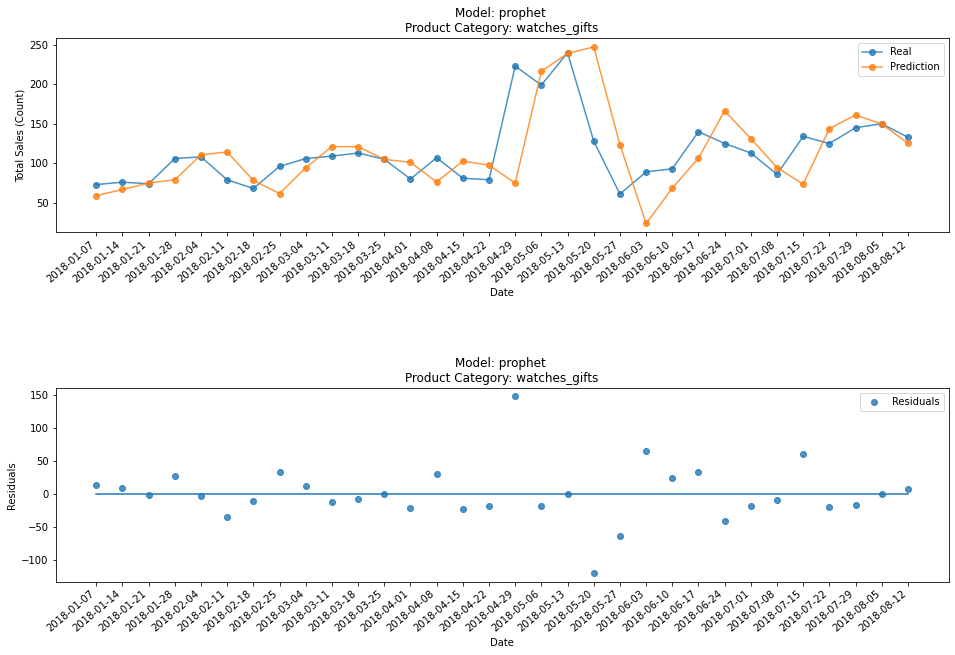

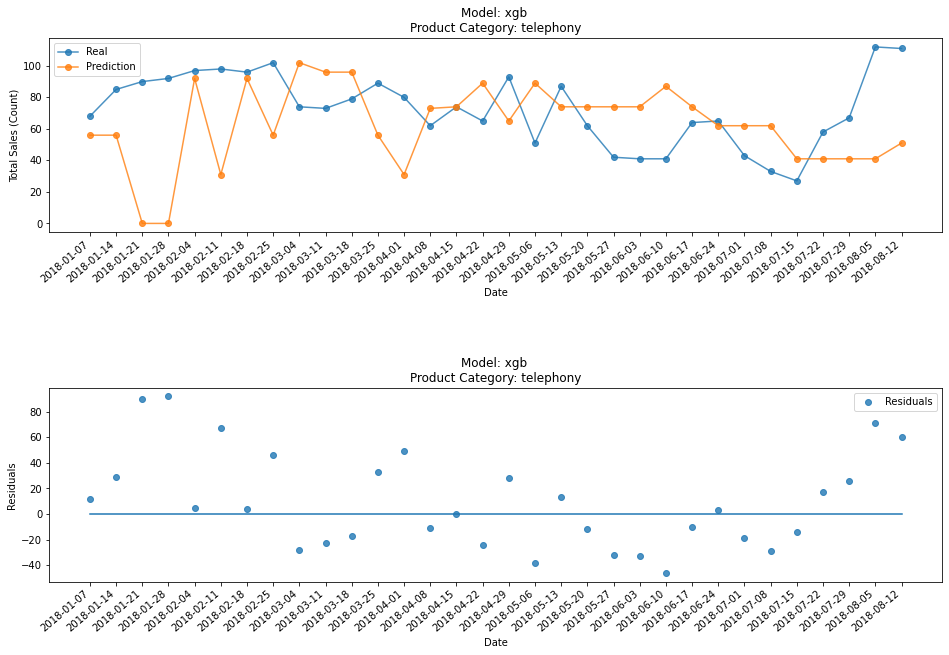

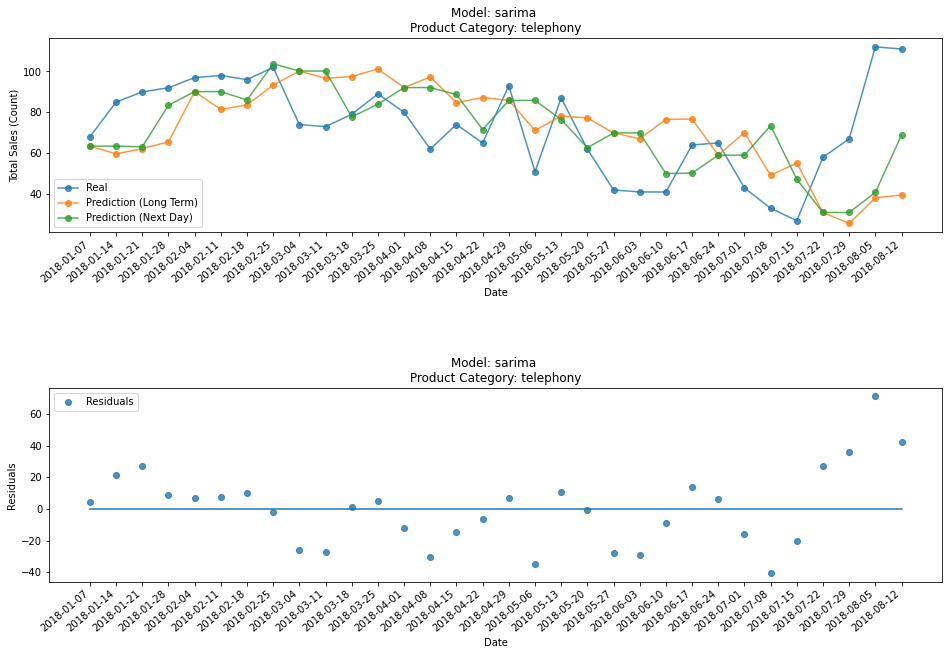

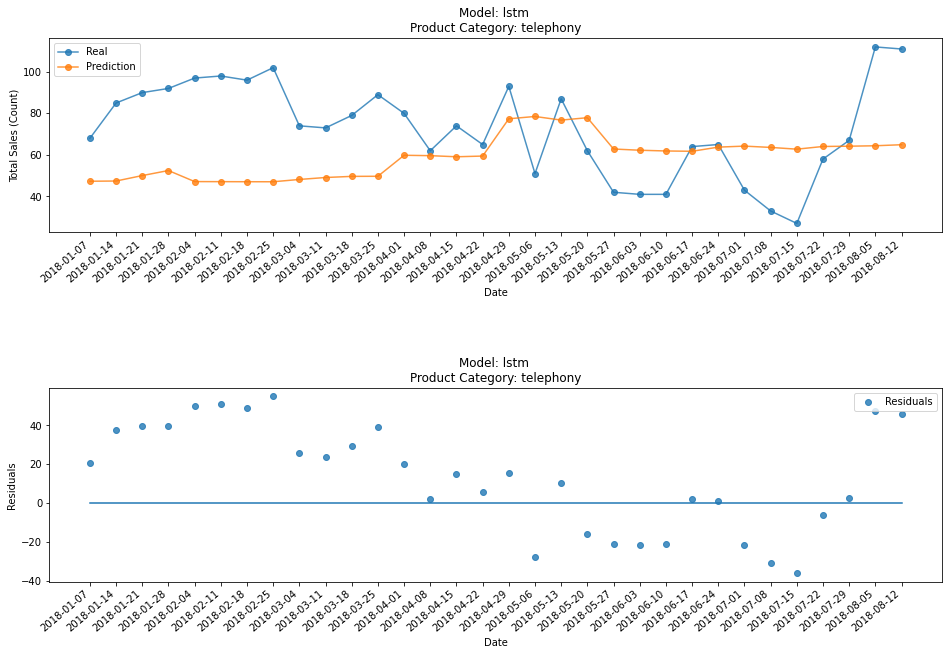

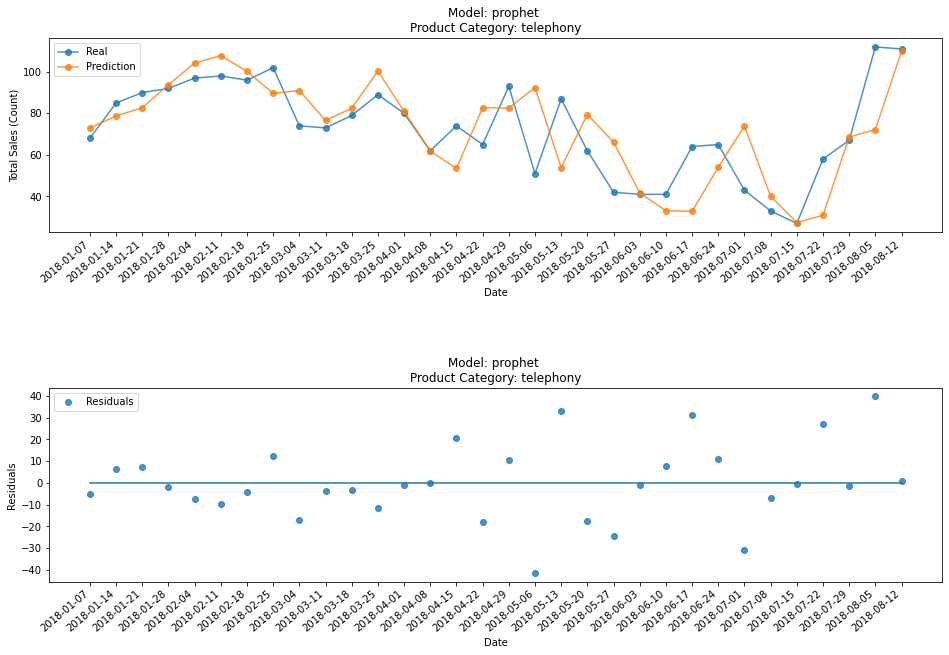

In [40]:
# Plot the forecast for each model

for prod_cat in prod_categories:
    
    temp = all_product_categories[prod_cat]
    temp.sort_index(inplace=True)

    for model in ['xgb','sarima','lstm','prophet']:
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecasts
        axs[0].plot(temp['y_true'], marker='o', label='Real', alpha=0.8)
        if model == 'sarima':
            axs[0].plot(temp[f'y_pred_lt_{model}'], marker='o', label='Prediction (Long Term)',alpha=0.8)
            axs[0].plot(temp[f'y_pred_{model}'], marker='o', label='Prediction (Next Day)',alpha=0.8)
        else:
            axs[0].plot(temp[f'y_pred_{model}'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} \nProduct Category: {prod_cat}')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Total Sales (Count)')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} \nProduct Category: {prod_cat}')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        plt.show()

    print('\n\n\n')
